# ISOKANN example with Feedforward Neural Network
ISOKANN is an algorithm that uses machine learning techniques to identify invariant subspaces of the Koopman operator.
The following implementation is based on the original ISOKANN version described in Ref. [1] and summarized in Ref. [2], but it implements a feed forward neural network with pytorch instead of tensorflow.

The following notebook shows how to implement ISOKANN in a simple and effective manner for a one-dimensional system, and is intended for teaching purposes.

__References__

[1] R. J. Rabben, S. Ray, M. Weber; ISOKANN: Invariant subspaces of Koopman operators learned by a neural network. 
[J. Chem. Phys. 153, 114109 (2020)](https://pubs.aip.org/aip/jcp/article-abstract/153/11/114109/199583/ISOKANN-Invariant-subspaces-of-Koopman-operators)

[2] L. Donati; [Notes about ISOKANN algorithm](https://www.zib.de/userpage/donati/SeminarSOSE2024/06/lecture_notes/L06.pdf)

## Preparation of the problem
The first cell is used to import the libraries used in the notebook.
In addition, the thermodynamic parameters of the problem and the potential energy function under consideration are defined.

Torch is on: cpu
Thermal energy: 2.4943389


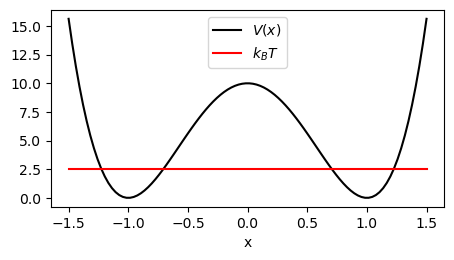

In [11]:
# Import libraries
import numpy as np
import sympy as sp
import torch as pt
from tqdm import tqdm
import scipy 
import matplotlib.pyplot as plt
import torch as pt


# Check if CUDA is available, otherwise use CPU
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print(f"Torch is on: {device}")

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# For figures
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches


# System parameters
Ndims  = 1
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu
gamma  = 1                           # ps-1 
sigma  = np.sqrt(2 * kB * T / mass / gamma )              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

print("Thermal energy:", kB * T)

# Potential energy function
Eb     =  10
x      =  sp.symbols('x')
V      =  Eb*(x**2 - 1)**2

gradV  =  V.diff(x)

V      =  sp.lambdify((x), V, modules=['numpy'])
gradV  =  sp.lambdify((x), gradV, modules=['numpy'])


## Plot potential
ax      =  np.linspace(-1.5, 1.5,100)

fig = plt.figure(figsize=(10*in2cm, 5*in2cm))

plt.plot(ax, V(ax), 'k-', label = r'$V(x)$')
plt.plot(ax, kB*T*np.ones(100),'r', label = r'$k_B T$')
plt.legend()
plt.xlabel('x')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)
#fig.savefig('potential.png', format='png', dpi=300, bbox_inches='tight')

# Trajectories production

The next cell generates the data used by ISOKANN to learn the membership functions.
The generation of data is specific to the problem under consideration. Alternatively, it is possible to load your own data produced by different code.

Here, we consider the overdamped Langevin dynamics:
1. We generate a sufficiently long trajectory that visits the dynamically relevant regions of the potential energy function using the Euler-Maruyama integration scheme.
During the simulation, _Npoints_ of the trajectory are stored in the variable _x0_ which has shape _(Npoints,)_.
2. The points saved in variable _x0_ are used as starting points for a set of short trajectories: _Nfinpoints_ for each starting point.
This produces an array _xt_ of shape _(Npoints, Nfinpoints)_.

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 652.11it/s]


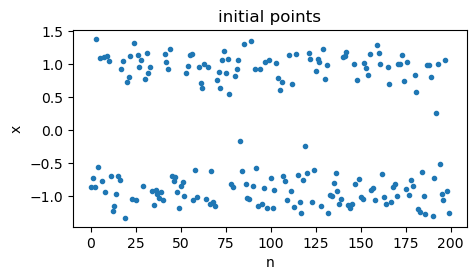

In [2]:
# Integrator parameters
dt  = 0.001
sdt = np.sqrt(dt)

# Lengh of initial trajectory
Nsteps1  = int(1e6)

# Number of starting points
Npoints  = 200

# Rates at which frames are saved
Nout     = int(Nsteps1 / Npoints) 

# Number of short trajectories per each starting point
Nfinpoints  = 50

# Length of short trajectories
Nsteps2     = 100

# Koopman operator lag time
tau      = Nsteps2 * dt


# Array where to store the Npoints
x0      = np.zeros(Npoints)

x       = -1

# Counter to save initial points
n = 0

## 1. Generate initial points with the Euler-Maruyama scheme
for k in tqdm(range(Nsteps1)):
    eta     =  np.random.normal(0, 1)
    force   =  - gradV(x)
    x       =  x + 1 / mass / gamma * force * dt + sigma * eta * sdt
    
    if k % Nout ==0:
        x0[n]  = x
        n     += 1
        
## 2. Generate final points with the Euler-Maruyama scheme
# Number of timesteps -> tau in K(tau)

# Initialize array xt
xt = np.zeros((Npoints, Nfinpoints))

for n in tqdm(range(Npoints)):

    x  = x0[n] * np.ones(Nfinpoints)
    
    for k in range(Nsteps2-1):

        eta     =  np.random.normal(0, 1, Nfinpoints)
        force   =  - gradV(x)
        x       =  x + 1 / mass / gamma * force * dt + sigma * eta * sdt
                    
    xt[n,:] = x

    

## Plot initial points
fig = plt.figure(figsize=(10*in2cm, 5*in2cm))

plt.plot(x0, '.')

plt.xlabel('n')
plt.ylabel('x')
plt.title('initial points')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)
#fig.savefig('initial_points.png', format='png', dpi=300, bbox_inches='tight')

## Power method with scale and shift function

In the next two cells, we implement the modified power method
\begin{eqnarray}
    f_{k+1}(x) =
    S \mathcal{K}_{\tau} f_k(x)\, ,
\end{eqnarray}

where $f_k$ is an arbitrary function, $\mathcal{K}_{\tau}$ is the Koopman operator, $S$ acts as a shift-scale function

\begin{equation}
    S\mathcal{K}_{\tau} f_k = \frac{\mathcal{K}_{\tau} f_k - \min\left(\mathcal{K}_{\tau} f_k\right)}{\max\left(\mathcal{K}_{\tau} f_k\right) - \min\left(\mathcal{K}_{\tau} f_k\right)} \, .
\end{equation}

Since we do not have an analytical expression of the Koopman operator, we approximate its action on the function $f_k$, evaluated in the point $x_0$, as 


\begin{eqnarray}
   \mathcal{K}_{\tau} f_k(x_0)
    &=& \mathbb{E}\left[ f_k(x_{\tau})\vert x_0\right] \\
    &\approx& 
    \frac{1}{M} \sum_{m=1}^M f_k(x_{\tau,m}\vert x_0)\, ,
\end{eqnarray}

where $x_{\tau,m}$ is a short trajectory of length $\tau$ starting in the initial point $x_0$. 
$M$ is the number of short trajectories _Nfinpoints_.

The choice of the function $f_k$ is arbitrary.
Here, as an initial function, we consider $y=f_0(x)$.
Then, we apply the Koopman operator, averaging over the short trajectories, and apply the shift and scale function.

However, these operations are carried out on single points $x_0$, so the result 
\begin{eqnarray}
y=f_{k+1}(x_0) = S \mathcal{K}_{\tau} f_k(x_0)\, ,
\end{eqnarray}
is a set of points for which we do not know the underlying analytic function $f_{k+1}$.

Finally, we use an interpolating function to determine an approximation of $f_{k+1}$.

In [16]:
# Thi cell contains classes and functions for ISOKANN
class NeuralNetwork(pt.nn.Module):
    """
    This class defined a feedforward neural network
    """
    def __init__(self, Nodes, enforce_positive=0):
        super(NeuralNetwork, self).__init__()

        # self parameters
        self.input_size        = Nodes[0]
        self.output_size       = Nodes[-1]
        self.NhiddenLayers     = len(Nodes) - 2
        self.Nodes             = Nodes

        self.enforce_positive  = enforce_positive

        # build NN architecture
        self.hidden_layers = pt.nn.ModuleList()

        # add layers
        self.hidden_layers.extend([pt.nn.Linear(self.input_size,    self.Nodes[1])])
        self.hidden_layers.extend([pt.nn.Linear(self.Nodes[1+l], self.Nodes[1+l+1]) for l in range(self.NhiddenLayers)])

        # the output of the last layer must be equal to 1
        #if self.Nodes[-1] > 1:
        #    self.hidden_layers.extend([pt.nn.Linear(self.Nodes[-1], 1)])

        # define activation function
        self.activation1  = pt.nn.Sigmoid()  # #
        self.activation2  = pt.nn.ReLU()
        self.activation3  = pt.nn.Softplus(10)

    def forward(self, X):

        # Pass input through each hidden layer but the last one
        for layer in self.hidden_layers[:-1]:
            X = self.activation1(layer(X))

        # Apply the last layer (but not the activation function)
        X = self.hidden_layers[-1](X)

        if self.enforce_positive == 1:
            X= self.activation3(X)  #.unsqueeze(1)

        return X.squeeze()

def trainNN(net, lr, wd, Nepochs, batch_size, X, Y):
    """
    This funciton is used to train the FNN
    """
    # Define the optimizer
    optimizer = pt.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

    # Define the loss function
    MSE = pt.nn.MSELoss()

    # Define an array where to store the loss
    loss_arr = np.zeros(Nepochs)

    # Train the model
    for epoch in range(Nepochs):

        permutation = pt.randperm(X.size()[0], device=device)

        for i in range(0, X.size()[0], batch_size):

            # Clear gradients for next training
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], Y[indices]

            # Make a new prediction
            new_points  =  net( batch_x )

            # measure the MSE
            loss = MSE(batch_y, new_points)

            # computes the gradients of the loss with respect to the model parameters using backpropagation.
            loss.backward()

            # updates the NN parameters
            optimizer.step()

        loss_arr[epoch] = loss.item()

    return loss_arr
    
def scale_and_shift(y):
    """
    scale and shift function for the modified power method
    """
    minarr = np.min(y)
    maxarr = np.max(y)
    hat_y  = (y - minarr) / (maxarr - minarr)

    return hat_y

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.33it/s]


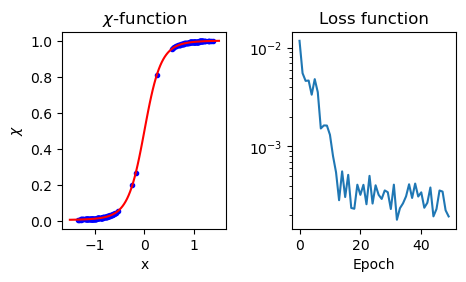

In [33]:
# This cell implements the modified power method 

# Convert x0 and add one dimension, such that pt_x0.shape = (Npoints, 1)
pt_x0     =  pt.tensor(x0, dtype=pt.float32, device=device).unsqueeze(1)

# Convert xt and add one dimension, such that pt_xt.shape = (Npoints, Nfinpoints, 1)
pt_xt     =  pt.tensor(xt, dtype=pt.float32, device=device).unsqueeze(2)

nodes = np.array([Ndims, 32, 32, 1])

# Define the interpolating function
f_k = NeuralNetwork( Nodes = nodes )


# Number of power method iterations
Niters = 50

# Initialize array to store the trainging loss
train_LOSS = np.empty(0, dtype = object)

for k in tqdm(range(Niters)):
    
    pt_chi  =  f_k( pt_xt )
    pt_y    =  pt.mean(pt_chi, axis=1)
    y       =  scale_and_shift(pt_y.cpu().detach().numpy())
    pt_y    =  pt.tensor(y, dtype=pt.float32, device=device)
    
    train_loss  =  trainNN(net = f_k, lr = 0.01, wd = 1e-5, Nepochs = 10, batch_size=50, X=pt_x0, Y=pt_y)
    train_LOSS  =  np.append(train_LOSS, train_loss[-1])


pt_ax  =  pt.tensor(ax, dtype=pt.float32).unsqueeze(1)
y      =  f_k(pt_ax).cpu().detach().numpy()
chi    =  f_k(pt_x0).cpu().detach().numpy()

## Plot chi function and loss function
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10*in2cm, 5*in2cm))

ax1.plot(x0, chi, 'b.')
ax1.plot(ax, y, 'r-')

#ax1.set_ylim(0,1)
ax1.set_xlabel('x')
ax1.set_ylabel(r'$\chi$')
ax1.set_title(r'$\chi$-function')


ax2.plot(train_LOSS)
ax2.set_xlabel('Epoch')
ax2.set_title('Loss function')
#ax2.set_ylim(0,0.01)
ax2.set_yscale('log')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.4, hspace=0.5)
#fig.savefig('chi.png', format='png', dpi=300, bbox_inches='tight')

## Calculation of rates

The Koopman operator acts on $\chi(x)$ as

\begin{eqnarray*}
\chi_{t+\tau}(x) &=& \mathcal{K}_{\tau} \chi_t(x) \cr
&=& a_1 \chi_t(x) + a_2\, .
\end{eqnarray*}

Solving the linear regression problem

\begin{eqnarray}
    \min\limits_{a_1,a_2}\Vert \mathcal{K}_{\tau} \chi(x) - a_1 \chi(x) - a_2 \Vert ,
\end{eqnarray}

the transition rate between fuzzy-sets is calculated as 

\begin{eqnarray}
\boxed{
\epsilon_1 = - \frac{1}{\tau} \log(a_1) \left( 1 + \frac{a_2}{a_1 - 1}\right) \, .
}
\end{eqnarray}

The derivation of this formula can be found in Refs. [3,4,5].

The calculation of the propagated $\chi$ function is realized as

\begin{eqnarray}
   \mathcal{K}_{\tau} \chi_0(x_0)
    &=& \mathbb{E}\left[ \chi_0(x_{\tau})\vert x_0\right] \\
    &\approx& 
    \frac{1}{M} \sum_{m=1}^M \chi_0(x_{\tau,m}\vert x_0)\, .
\end{eqnarray}

__References__

[3] M. Weber, N. Ernst; A fuzzy-set theoretical framework for computing exit rates of rare events in potential-driven diffusion processes. 
[arXiv:1708.00679 (2017)](https://arxiv.org/abs/1708.00679)

[4] M. Weber; Implications of PCCA+ in Molecular Simulation. 
[Comput. 6, (2018)](https://www.mdpi.com/2079-3197/6/1/20)

[5] L. Donati; [Notes about ISOKANN algorithm](https://www.zib.de/userpage/donati/SeminarSOSE2024/06/lecture_notes/L06.pdf)

In [35]:
def exit_rates_from_chi(tau, chi_0, chi_tau):
    
    #
    chi1      = chi_0[:,0]
    chi2      = chi_0[:,1]

    #
    prop_chi1 = chi_tau[:,0]
    prop_chi2 = chi_tau[:,1]

    res1 = scipy.stats.linregress(chi1, prop_chi1)
    res2 = scipy.stats.linregress(chi2, prop_chi2)

    rate1  = - 1 / tau * np.log( res1.slope ) * ( 1 + res1.intercept  / ( res1.slope - 1 ))
    rate2  = - 1 / tau * np.log( res2.slope ) * ( 1 + res2.intercept  / ( res2.slope - 1 ))
    
    #

    print('Exit rate 1:', rate1)
    print('Exit rate 2:', rate2)

    return rate1, rate2

chi_0   = f_k(pt_x0).cpu().detach().numpy()
y       = f_k(pt_xt).cpu().detach().numpy()
chi_tau = np.mean( y, axis=1 )

chi_0         = np.array([chi_0,      1 - chi_0]).T
chi_tau       = np.array([chi_tau,    1 - chi_tau]).T


rate1, rate2  = exit_rates_from_chi(tau, chi_0, chi_tau)

Exit rate 1: 0.144686192834004
Exit rate 2: 0.15388558476715591
